# Local Surrogate Model - LIME
## TAIC 2 - Atividade 3

Autor: João Vitor Mergulhão

Base de dados usada na atividade: https://www.kaggle.com/datasets/ahmeduzaki/global-earthquake-tsunami-risk-assessment-dataset

In [307]:
import pandas
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from lime import lime_tabular

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score

## Treina Modelo de Random Forest

In [308]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "earthquake_data_tsunami.csv"

# Load the latest version
df = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "ahmeduzaki/global-earthquake-tsunami-risk-assessment-dataset",
  file_path)

In [309]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 782 entries, 0 to 781
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   magnitude  782 non-null    float64
 1   cdi        782 non-null    int64  
 2   mmi        782 non-null    int64  
 3   sig        782 non-null    int64  
 4   nst        782 non-null    int64  
 5   dmin       782 non-null    float64
 6   gap        782 non-null    float64
 7   depth      782 non-null    float64
 8   latitude   782 non-null    float64
 9   longitude  782 non-null    float64
 10  Year       782 non-null    int64  
 11  Month      782 non-null    int64  
 12  tsunami    782 non-null    int64  
dtypes: float64(6), int64(7)
memory usage: 79.6 KB


In [310]:
df.head()

,magnitude,cdi,mmi,sig,nst,dmin,gap,depth,latitude,longitude,Year,Month,tsunami
0,7.0,8,7,768,117,0.509,17.0,14.000,-9.7963,159.596,2022,11,1
1,6.9,4,4,735,99,2.229,34.0,25.000,-4.9559,100.738,2022,11,0
2,7.0,3,3,755,147,3.125,18.0,579.000,-20.0508,-178.346,2022,11,1
3,7.3,5,5,833,149,1.865,21.0,37.000,-19.2918,-172.129,2022,11,1
4,6.6,0,2,670,131,4.998,27.0,624.464,-25.5948,178.278,2022,11,1


In [311]:
X = df.drop(columns=["tsunami"])
y = df["tsunami"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [312]:
random_forest_model = RandomForestClassifier()
random_forest_model.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [313]:
y_pred = random_forest_model.predict(X_test)
y_pred_proba = random_forest_model.predict_proba(X_test)

In [314]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score

def show_classification_report(y_true, y_pred, target_names):
    roc_auc = roc_auc_score(y_true, y_pred_proba[:, 1])

    cm = confusion_matrix(y_true, y_pred)

    print("Classification Report:\n")
    print(f"ROC AUC Score: {roc_auc:.4f}\n")

    classification_report(y_test, y_pred, target_names=['No Tsunami', 'Tsunami'])
    print(classification_report(y_test, y_pred, target_names=['No Tsunami', 'Tsunami']))

    # Crie a visualização
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm, 
        display_labels=['No Tsunami', 'Tsunami']
    )

    # Use o argumento 'cmap' para definir a nova paleta de cores
    disp.plot(cmap='Blues')

Classification Report:

ROC AUC Score: 0.9658

              precision    recall  f1-score   support

  No Tsunami       0.97      0.93      0.95        96
     Tsunami       0.89      0.95      0.92        61

    accuracy                           0.94       157
   macro avg       0.93      0.94      0.93       157
weighted avg       0.94      0.94      0.94       157



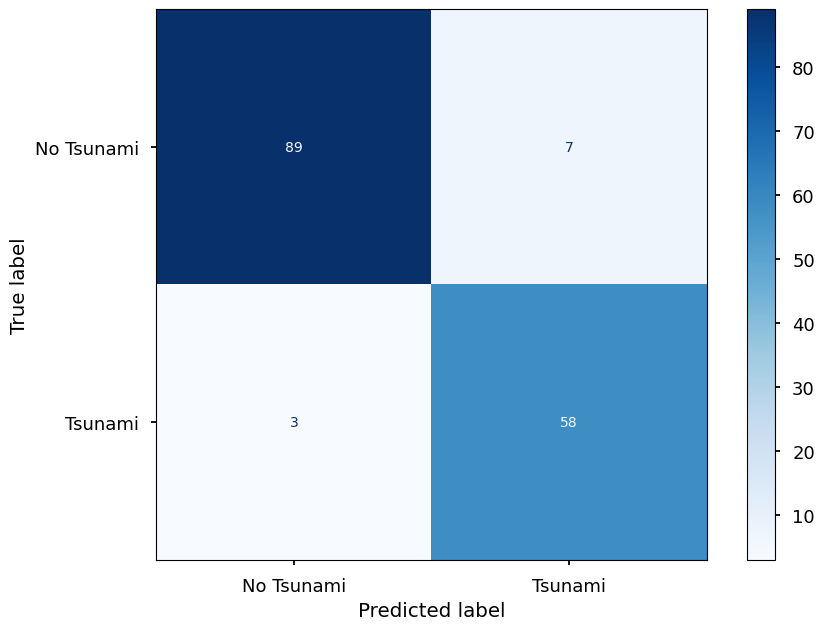

In [315]:
show_classification_report(y_test, y_pred, target_names=['No Tsunami', 'Tsunami'])

## LIME

In [316]:
def explain_with_lime(model, X_train, X_test, sample_id):
    explainer = lime_tabular.LimeTabularExplainer(
        training_data=np.array(X_train),
        feature_names=X_train.columns,
        class_names=['No Tsunami', 'Tsunami'],
        mode='classification'
    )

    exp = explainer.explain_instance(
        data_row=X_test.iloc[sample_id],
        predict_fn=model.predict_proba)
    
    return exp.as_list()

In [317]:

def plot_lime_explanation(explanation_list):
    features = [x[0] for x in explanation_list]
    weights = [x[1] for x in explanation_list]

    features.reverse()
    weights.reverse()

    colors = ['#28a745' if w > 0 else '#dc3545' for w in weights]

    plt.style.use('seaborn-v0_8-talk') 
    fig, ax = plt.subplots(figsize=(8, 6))

    ax.barh(features, weights, color=colors)

    ax.set_title('Análise de Contribuição das Features (LIME)', fontsize=18, pad=20)
    ax.set_xlabel('Peso (Contribuição para a Previsão)', fontsize=12)
    ax.set_ylabel('Feature', fontsize=12)

    ax.axvline(0, color='black', linewidth=0.8, linestyle='--')

    fig.tight_layout()

    plt.show()

In [318]:
sample_id = 100  # Índice da amostra de teste a ser explicada

prediction = random_forest_model.predict(X_test.iloc[sample_id].values.reshape(1, -1))
true_class = y_test.iloc[sample_id]

print(f"True class for sample {sample_id}: {true_class}")
print(f"Predicted class for sample {sample_id}: {prediction[0]}")

True class for sample 100: 1
Predicted class for sample 100: 1


/Users/jvlm/repositories/explainable_ai/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [319]:
# Pega a explicação como uma lista de tuplas no formato ('feature', peso)
explanation_list = explain_with_lime(random_forest_model, X_train, X_test, sample_id)
explanation_list.sort(key=lambda x: x[1], reverse=True)  # Sort by weight

# Imprime a lista para análise
print("Explicação em formato de lista:")
for feature, weight in explanation_list:
    print(f"Feature: {feature: <30} | Peso: {weight}")

Explicação em formato de lista:
Feature: 2013.00 < Year <= 2017.00      | Peso: 0.2774665467325209
Feature: dmin > 1.80                    | Peso: 0.11537644951040596
Feature: longitude > 147.88             | Peso: 0.09510232986412746
Feature: nst <= 0.00                    | Peso: 0.07046853524187169
Feature: 754.00 < sig <= 918.00         | Peso: 0.01378952598313623
Feature: 13.00 < depth <= 25.70         | Peso: 0.011122978751758196
Feature: 3.00 < Month <= 7.00           | Peso: 0.010618456809992169
Feature: 6.00 < mmi <= 7.00             | Peso: 0.002198830487968011
Feature: -14.60 < latitude <= -2.31     | Peso: -0.0093936118435641
Feature: cdi <= 0.00                    | Peso: -0.012897685978329179


/Users/jvlm/repositories/explainable_ai/.venv/lib/python3.13/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/jvlm/repositories/explainable_ai/.venv/lib/python3.13/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/jvlm/repositories/explainable_ai/.venv/lib/python3.13/site-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will a

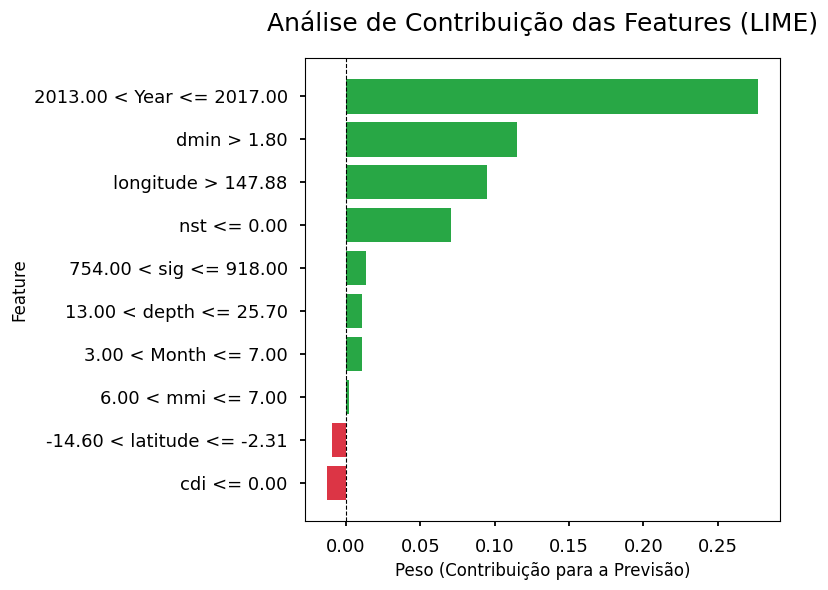

In [320]:
plot_lime_explanation(explanation_list)

In [321]:
sample_id = 120 

prediction = random_forest_model.predict(X_test.iloc[sample_id].values.reshape(1, -1))
true_class = y_test.iloc[sample_id]

print(f"True class for sample {sample_id}: {true_class}")
print(f"Predicted class for sample {sample_id}: {prediction[0]}")

True class for sample 120: 0
Predicted class for sample 120: 0


/Users/jvlm/repositories/explainable_ai/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


/Users/jvlm/repositories/explainable_ai/.venv/lib/python3.13/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/jvlm/repositories/explainable_ai/.venv/lib/python3.13/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/jvlm/repositories/explainable_ai/.venv/lib/python3.13/site-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will a

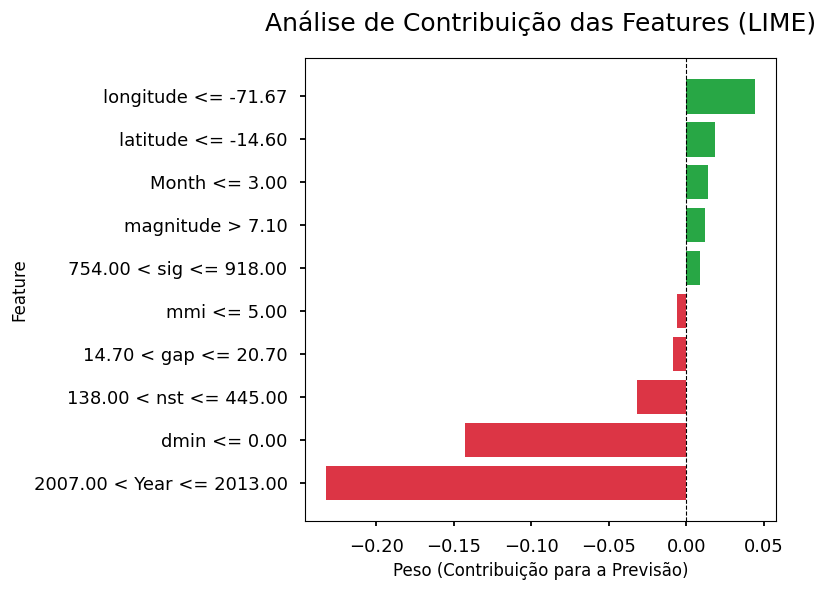

In [322]:
explanation_list = explain_with_lime(random_forest_model, X_train, X_test, sample_id)
explanation_list.sort(key=lambda x: x[1], reverse=True) 

plot_lime_explanation(explanation_list)

## Visualização com 2 Variáveis

In [323]:
X = df[['latitude', 'Year']]
y = df["tsunami"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

random_forest_model = RandomForestClassifier()
random_forest_model.fit(X_train, y_train)

y_pred = random_forest_model.predict(X_test)
y_pred_proba = random_forest_model.predict_proba(X_test)

Classification Report:

ROC AUC Score: 0.9158

              precision    recall  f1-score   support

  No Tsunami       0.88      0.88      0.88        96
     Tsunami       0.80      0.80      0.80        61

    accuracy                           0.85       157
   macro avg       0.84      0.84      0.84       157
weighted avg       0.85      0.85      0.85       157



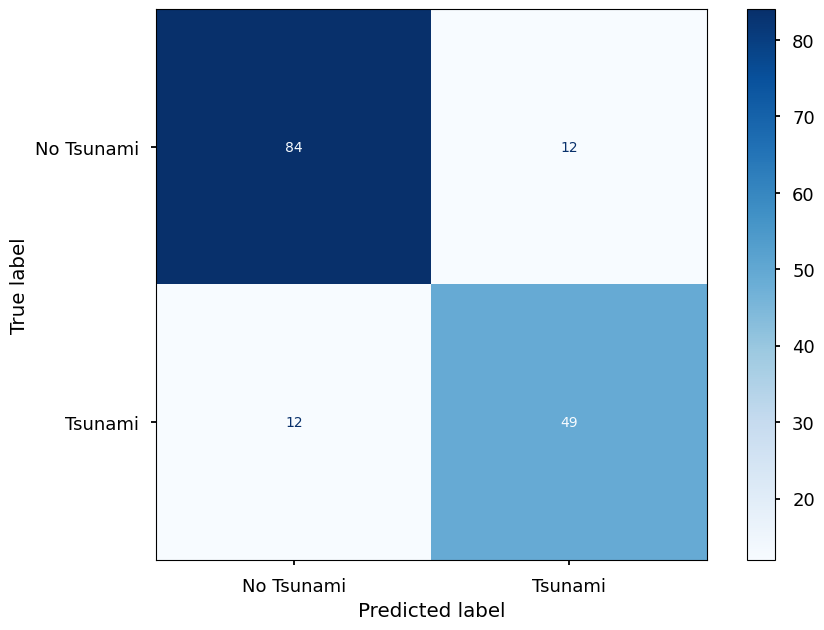

In [324]:
show_classification_report(y_test, y_pred, target_names=['No Tsunami', 'Tsunami'])

/Users/jvlm/repositories/explainable_ai/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/jvlm/repositories/explainable_ai/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


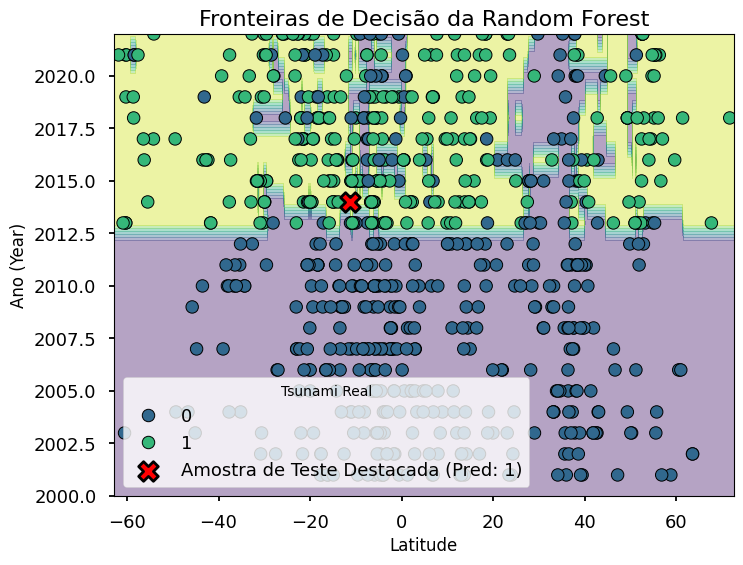

In [325]:
sample_id = 100

# Vamos criar uma grade que cobre toda a área dos seus dados de treino.
x_min, x_max = X['latitude'].min() - 1, X['latitude'].max() + 1
y_min, y_max = X['Year'].min() - 1, X['Year'].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 1))

Z = random_forest_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape) # Remodelamos o resultado para ter o mesmo formato da grade.

# --- Passo 3: Plotar o resultado ---
# Agora, criamos o gráfico final.
plt.figure(figsize=(8, 6))

# contourf desenha o fundo colorido com base nas previsões (Z) da nossa grade.
plt.contourf(xx, yy, Z, alpha=0.4, cmap='viridis')

X_test.iloc[sample_id]['latitude']
X_test.iloc[sample_id]['Year']
highlight_latitude = X_test.iloc[sample_id]['latitude']
highlight_year = X_test.iloc[sample_id]['Year']
predicted_class = random_forest_model.predict(X_test.iloc[sample_id].values.reshape(1, -1))[0]
highlight_label = 'Amostra de Teste Destacada'

# Plotamos os pontos de teste por cima para ver como eles se encaixam nas regiões.
# Usamos o seaborn para facilitar a coloração dos pontos com base na classe real.
sns.scatterplot(x=X['latitude'], y=X['Year'], hue=y,
                palette='viridis', alpha=1, edgecolor='k', s=80)

plt.scatter(highlight_latitude, highlight_year,
            color='red',           # Cor do ponto
            marker='X',            # Formato do ponto (ex: 'X', 'o', 's', '*')
            s=200,                 # Tamanho do ponto (maior para destacar)
            edgecolor='black',     # Borda do ponto
            linewidth=2,           # Largura da borda
            label=f'{highlight_label} (Pred: {predicted_class})') # Adiciona à legenda

plt.title('Fronteiras de Decisão da Random Forest', fontsize=16)
plt.xlabel('Latitude', fontsize=12)
plt.ylabel('Ano (Year)', fontsize=12)
plt.legend(title='Tsunami Real')
plt.show()

## Conclusão

O LIME é uma ferramenta útil para interpretar o comportamento do modelo para uma amostra específica. Nos casos analisados, conseguimos visualizar quais características foram mais relevantes para a predição do modelo, permitindo uma melhor compreensão do seu funcionamento interno.

Para o sample ID 100, observamos que as variáveis Year, dmin, longitude e nst tiveram grande impacto positivo na predição de tsunami, enquanto latitude e cdi foram as únicas com impacto negativo. Já para o sample ID 120, a longitude também teve o maior impacto positivo , mas as variáveis com impacto negativo se destacam, em especial Year e dmin. Isso sugere que o modelo pode estar considerando diferentes aspectos dos dados para diferentes amostras, o que é uma característica interessante a ser explorada.